# Kish Basin Salt Caverns

<https://hyss.ie/>

In [1]:
import glob
import itertools
import os

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import shapely
from geocube.api.core import make_geocube

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "kish-basin")
FILE_NAME = "Kish-Basin-dat-files.zip"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# boundary data
ie = gpd.read_file(
    os.path.join("data", "boundaries.gpkg"), layer="NUTS_RG_01M_2021_4326_IE"
)

crs = 23029

## Read data layers

In [3]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[1][:-4]]["data"] = (
            os.path.split(dat_file)[1][:-4]
        )

    # find data resolution
    gdf_xr = (
        gdf[os.path.split(dat_file)[1][:-4]].set_index(["X", "Y"]).to_xarray()
    )
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    ds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # keep only points corresponding to zones of interest in the dataframe
    zones = gdf.loc[gdf["data"].str.contains("Zone")]

    # create zones of interest polygon
    zones = gpd.GeoDataFrame(geometry=zones.buffer(100).envelope).dissolve()

    # create extent polygon
    extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (extent[" X"][0], extent[" Y"][0]),
            (extent[" X"][1], extent[" Y"][1]),
            (extent[" X"][2], extent[" Y"][2]),
            (extent[" X"][3], extent[" Y"][3])
        ]),
        crs=crs
    )

    return ds, zones, extent

In [4]:
ds, zones, extent = read_dat_file(DATA_DIR, dat_crs=crs)

### Halite layers

In [5]:
ds

<xarray.Dataset>
Dimensions:      (data: 19, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
  * data         (data) <U66 'Flyde Halite Base Depth XYZ Meters' ... 'Rossal...
    spatial_ref  int64 0
Data variables:
    Z            (data, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [6]:
ds.rio.crs

CRS.from_epsg(23029)

In [7]:
ds.rio.resolution()

(200.0, -200.0)

In [8]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

### Zones of interest boundaries

In [9]:
zones

,geometry
0,"MULTIPOLYGON (((701700.000 5899700.000, 701700..."


In [10]:
zones.bounds

,minx,miny,maxx,maxy
0,697900.0,5894100.0,726900.0,5929500.0


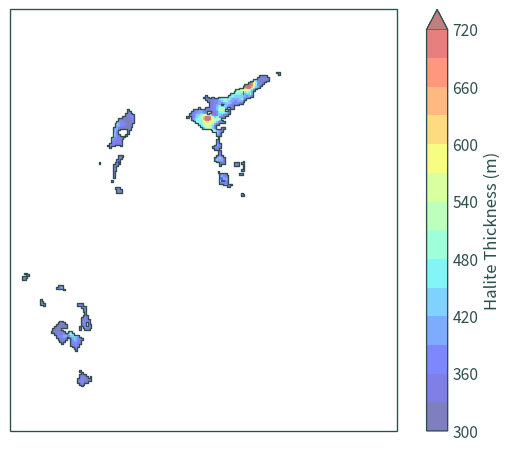

In [11]:
ax = plt.axes(projection=ccrs.epsg(crs))
zones.boundary.plot(color="darkslategrey", linewidth=1, ax=ax)
ds.sel(
    data="Rossall Halite Thickness - Zone Of Interest - XYZ Meters"
)["Z"].plot(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    extend="max",
    cbar_kwargs={"label": "Halite Thickness (m)"}
)
ds.sel(
    data="Presall Halite Thickness - Zone Of Interest - XYZ Meters-corrected"
)["Z"].plot(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    extend="max",
    add_colorbar=False
)
ds.sel(
    data="Flyde Halite Thickness - Zone Of Interest - XYZ Meters"
)["Z"].plot(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    extend="max",
    add_colorbar=False
)
plt.title(None)
plt.tight_layout()

### Cavern specifications

In [12]:
# cavern specifications
diameter = 84
separation = diameter * 4

In [13]:
separation

336

### Generate salt cavern grid

In [14]:
# use data bounds
# xmin, ymin, xmax, ymax = ds.rio.bounds()
xmin, ymin, xmax, ymax = zones.bounds.values[0]
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + separation, separation):
    for y0 in np.arange(ymin, ymax + separation, separation):
        # bounds
        x1 = x0 - separation
        y1 = y0 + separation
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid_cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

In [15]:
# verify separation distance
x0 - x1, y1 - y0

(336.0, 336.0)

In [16]:
grid_cells.head()

,geometry
0,"POLYGON ((697564.000 5894100.000, 697564.000 5..."
1,"POLYGON ((697564.000 5894436.000, 697564.000 5..."
2,"POLYGON ((697564.000 5894772.000, 697564.000 5..."
3,"POLYGON ((697564.000 5895108.000, 697564.000 5..."
4,"POLYGON ((697564.000 5895444.000, 697564.000 5..."


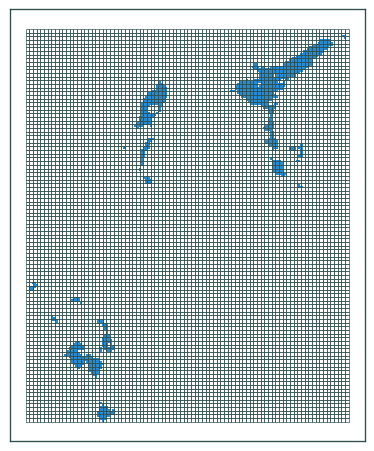

In [17]:
ax = grid_cells.boundary.plot(linewidth=.5, color="darkslategrey")
zones.plot(ax=ax, linewidth=1)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

### Caverns in zones of interest

In [18]:
caverns = gpd.sjoin(
    gpd.GeoDataFrame(geometry=grid_cells.centroid.buffer(diameter / 2)),
    zones,
    predicate="within"
)

In [19]:
caverns.head()

,geometry,index_right
143,"POLYGON ((698110.000 5906364.000, 698109.798 5...",0
250,"POLYGON ((698446.000 5906364.000, 698445.798 5...",0
251,"POLYGON ((698446.000 5906700.000, 698445.798 5...",0
883,"POLYGON ((700462.000 5903340.000, 700461.798 5...",0
1195,"POLYGON ((701470.000 5900316.000, 701469.798 5...",0


In [20]:
len(caverns)

296

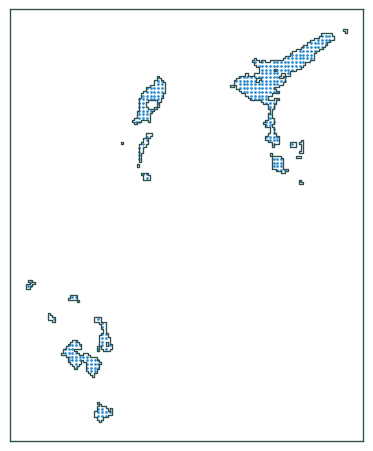

In [21]:
ax = caverns.centroid.plot(markersize=1)
zones.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

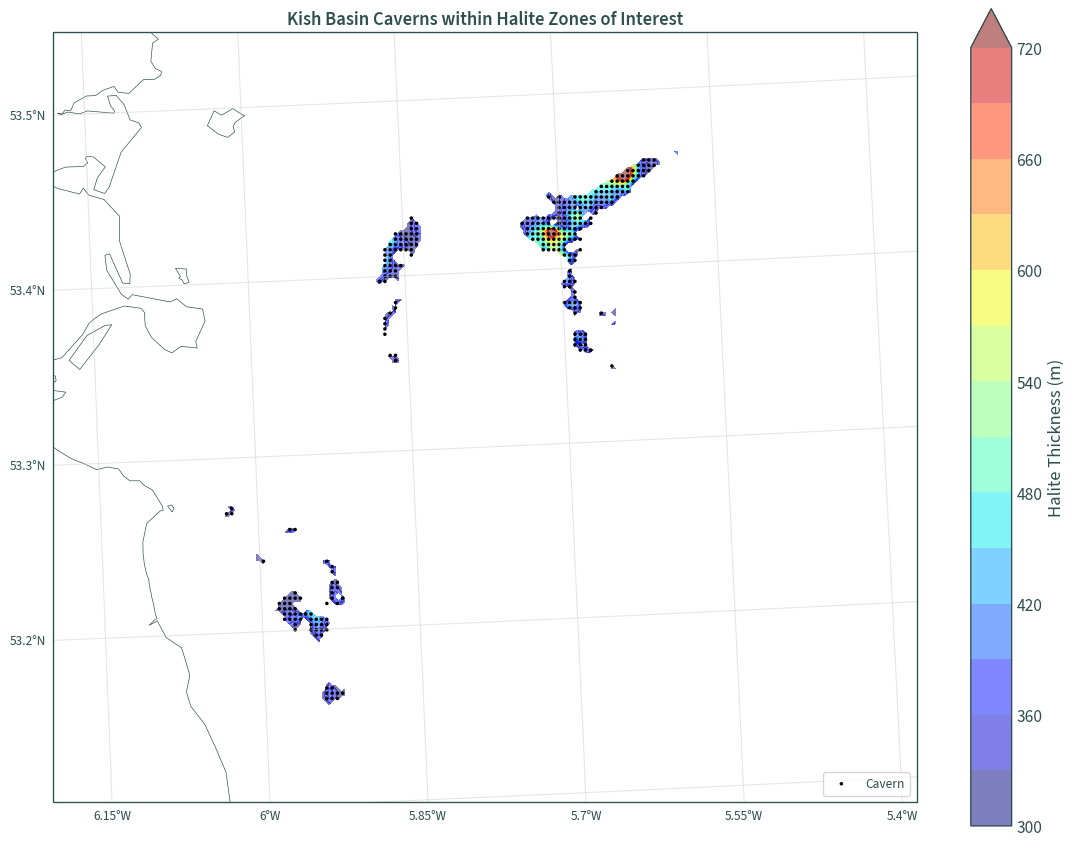

In [22]:
plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.epsg(crs))
ds.sel(
    data="Rossall Halite Thickness - Zone Of Interest - XYZ Meters"
)["Z"].plot.contourf(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    xlim=(extent.bounds["minx"][0], extent.bounds["maxx"][0]),
    ylim=(extent.bounds["miny"][0], extent.bounds["maxy"][0]),
    extend="max",
    cbar_kwargs={"label": "Halite Thickness (m)"}
)
ds.sel(
    data="Presall Halite Thickness - Zone Of Interest - XYZ Meters-corrected"
)["Z"].plot.contourf(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    extend="max",
    add_colorbar=False
)
ds.sel(
    data="Flyde Halite Thickness - Zone Of Interest - XYZ Meters"
)["Z"].plot.contourf(
    cmap="jet",
    alpha=.5,
    levels=[300 + 30 * n for n in range(15)],
    extend="max",
    add_colorbar=False
)
caverns.centroid.plot(
    ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
)
ie.to_crs(crs).boundary.plot(ax=ax, edgecolor="darkslategrey", linewidth=.5)
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=.5)
plt.legend(loc="lower right")
plt.title("Kish Basin Caverns within Halite Zones of Interest")
plt.tight_layout()
plt.show()

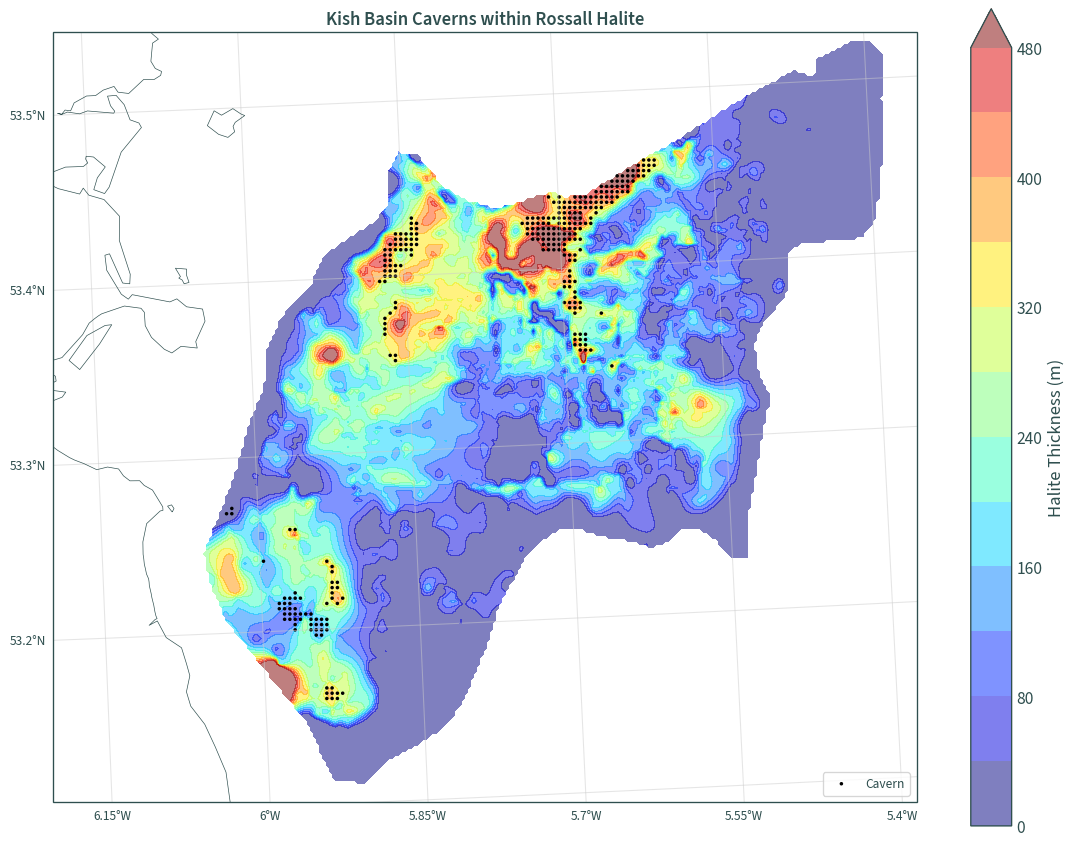

In [23]:
plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.epsg(crs))
ds.sel(data="Rossall Halite Thickness XYZ Meters")["Z"].plot.contourf(
    cmap="jet",
    alpha=.5,
    robust=True,
    levels=15,
    xlim=(extent.bounds["minx"][0], extent.bounds["maxx"][0]),
    ylim=(extent.bounds["miny"][0], extent.bounds["maxy"][0]),
    cbar_kwargs={"label": "Halite Thickness (m)"}
)
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=.5)
caverns.centroid.plot(
    ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
)
ie.to_crs(crs).boundary.plot(ax=ax, edgecolor="darkslategrey", linewidth=.5)
plt.legend(loc="lower right")
plt.title("Kish Basin Caverns within Rossall Halite")
plt.tight_layout()
plt.show()